# Multiple Linear Regression on WHO Life Expectancy Data

Aim is to make a model that can predict life expectancy of a country based on other WHO health data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Data preperation

In [2]:
df = pd.read_csv("Life Expectancy Data.csv")
df = df[df['Year']==2015]
df = df.drop(['Country','Year'], axis=1)
df = pd.get_dummies(df, columns=['Status'])
print(df.head())

    Life expectancy   Adult Mortality  infant deaths  Alcohol  \
0               65.0            263.0             62     0.01   
16              77.8             74.0              0     4.60   
32              75.6             19.0             21      NaN   
48              52.4            335.0             66      NaN   
64              76.4             13.0              0      NaN   

    percentage expenditure  Hepatitis B  Measles    BMI   under-five deaths   \
0                71.279624         65.0      1154   19.1                  83   
16              364.975229         99.0         0   58.0                   0   
32                0.000000         95.0        63   59.5                  24   
48                0.000000         64.0       118   23.3                  98   
64                0.000000         99.0         0   47.7                   0   

    Polio  ...  Diphtheria    HIV/AIDS           GDP  Population  \
0     6.0  ...         65.0        0.1    584.259210  337364

Create dummy variables for categorical data and drop irrelevant columns.

## Feature Extraction

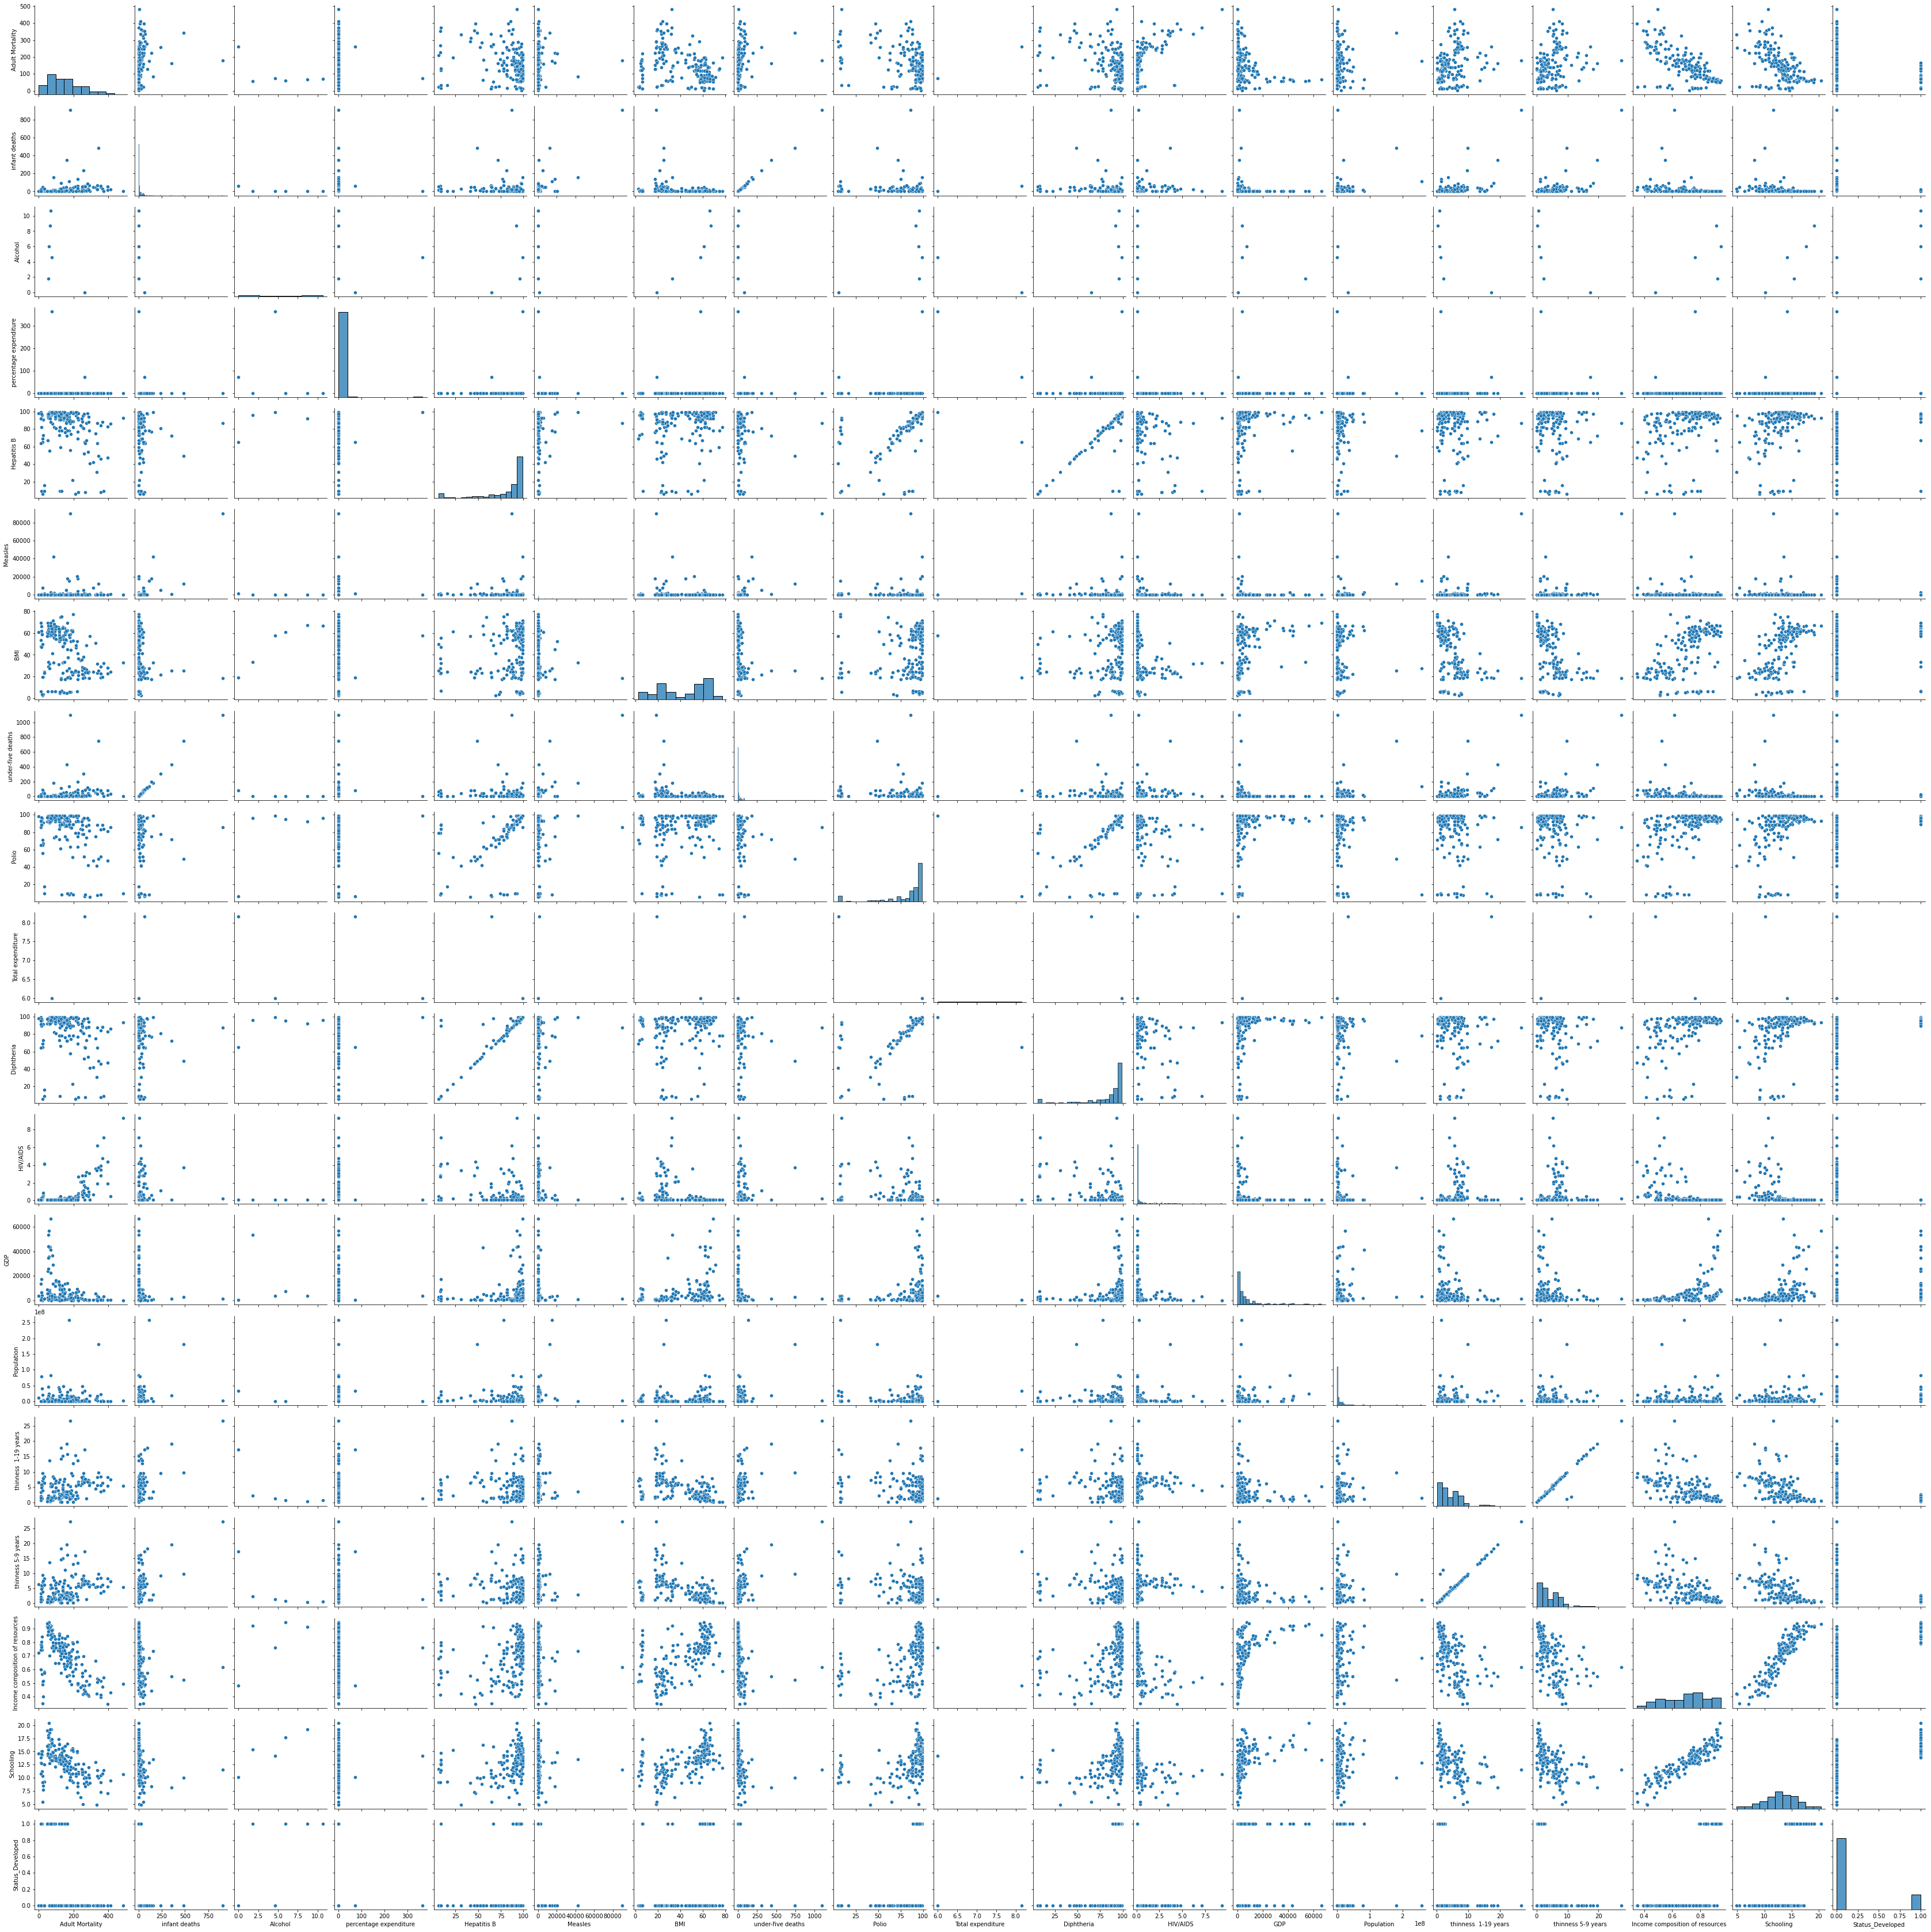

In [3]:
sns.pairplot(df.iloc[:, 1:20])
plt.show()

Visualise correlation between variables and get a rough idea of how they are linked. Lots of linear correlation so linear regression is appropriate.

21


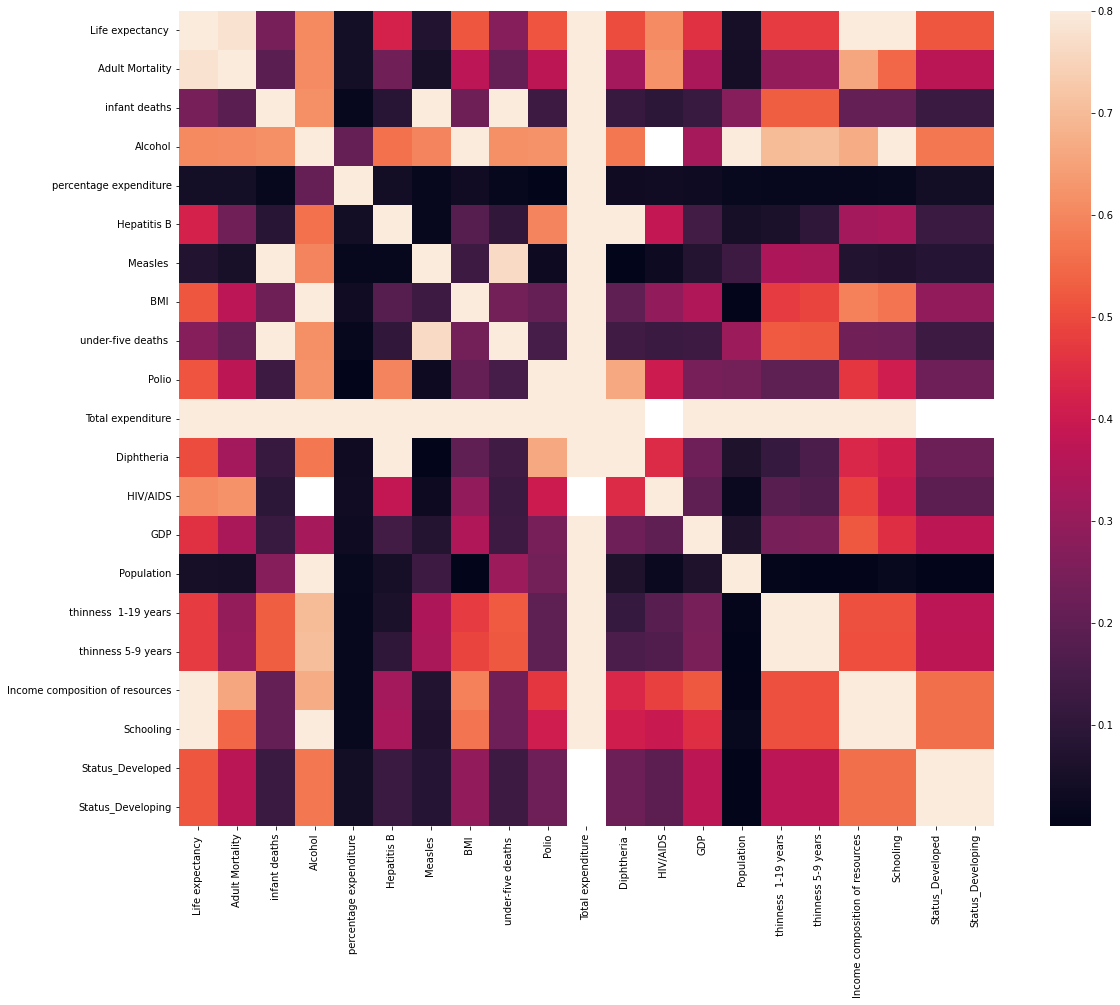

In [4]:
corrmat = df.corr().abs()
#Correlation Matrix in full
f, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corrmat, vmax=.8, square=True);
print(len(df.columns))

Correlation matrix of remaining variables. Can see outlier in Total Expenditure so needs further investigation. Can see some highly correlated variables so may need to deal with them.

In [5]:
print(df.info())
print()
print('Number of NA values in Total Expenditure: ')
print((df['Total expenditure'].isna().sum()))
print()
print('Number of NA values in Alcohol: ')
print((df['Alcohol'].isna().sum()))
#mostly NA values so remove
df=df.drop(['Total expenditure'], axis=1)
#same for alcohol so drop
df=df.drop(['Alcohol'], axis=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183 entries, 0 to 2922
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Life expectancy                  183 non-null    float64
 1   Adult Mortality                  183 non-null    float64
 2   infant deaths                    183 non-null    int64  
 3   Alcohol                          6 non-null      float64
 4   percentage expenditure           183 non-null    float64
 5   Hepatitis B                      174 non-null    float64
 6   Measles                          183 non-null    int64  
 7    BMI                             181 non-null    float64
 8   under-five deaths                183 non-null    int64  
 9   Polio                            183 non-null    float64
 10  Total expenditure                2 non-null      float64
 11  Diphtheria                       183 non-null    float64
 12   HIV/AIDS            

181 of 183 rows contain null values for Total Expenditure and 177 for Alcohol so simply remove these features.

19


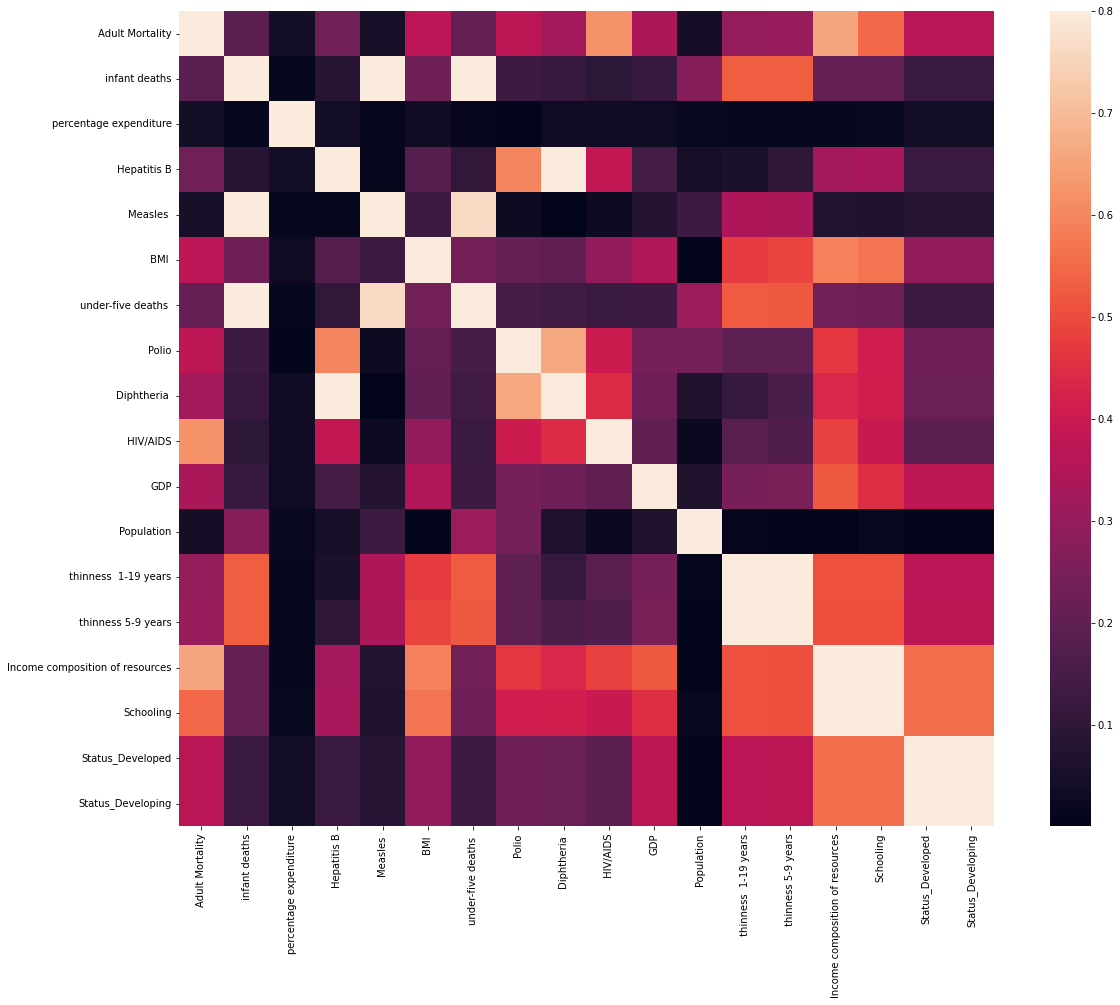

In [6]:
corrmat = df.drop(['Life expectancy '],axis=1).corr().abs()
#Correlation Matrix in full
f, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corrmat, vmax=.8, square=True);
print(len(df.columns))

New correlation matrix- much less highly correlated features. Still needs analysis.

In [7]:
upper_tri = corrmat.where(np.triu(np.ones(corrmat.shape), k=1).astype(bool))
corr_list = upper_tri.stack().sort_values(ascending=False)
print('Highest correlated features:')
print()
print(corr_list.head(50))

Highest correlated features:

Status_Developed                 Status_Developing                  1.000000
infant deaths                    under-five deaths                  0.994196
 thinness  1-19 years             thinness 5-9 years                0.973195
Income composition of resources  Schooling                          0.917514
Hepatitis B                      Diphtheria                         0.915220
infant deaths                    Measles                            0.800859
Measles                          under-five deaths                  0.764908
Polio                            Diphtheria                         0.661635
Adult Mortality                  Income composition of resources    0.657258
                                  HIV/AIDS                          0.621012
Hepatitis B                      Polio                              0.594559
 BMI                             Income composition of resources    0.589784
                                 Schooling    

Drop any columns that have very high correlation with others (have no effect on model due to repeat data so drop to help dimensionality).

In [8]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
print('Features to drop:'); 
print(to_drop)
df = df.drop(to_drop,axis=1)

Features to drop:
['under-five deaths ', 'Diphtheria ', ' thinness 5-9 years', 'Schooling', 'Status_Developing']


## Models

Run linear regression on several cases of dealing with null values

### 1. Delete rows with missing data

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

column_names = df.columns
updated_df1 = df.dropna(axis=0)

#scale data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
updated_df1 = scaler.fit_transform(updated_df1)
updated_df1 =pd.DataFrame(updated_df1, columns=column_names)

y1 = updated_df1['Life expectancy ']
updated_df1 = updated_df1.drop(['Life expectancy '], axis=1)

X_train, X_test,y_train,y_test = train_test_split(updated_df1,y1,test_size=0.3, random_state=2)
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Mean absolute error: {mae:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')
print(f'R^2 on train data: {lr.score(X_train, y_train)}')
print(f'R^2 on test data: {lr.score(X_test, y_test)}')

Mean absolute error: 0.08
Mean squared error: 0.01
Root mean squared error: 0.11
R^2 on train data: 0.9170121782990737
R^2 on test data: 0.7964185403022115


Good generalisation, 79.6% of data predicted accurately. Very low errors.

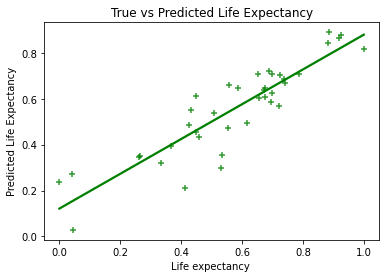

In [10]:
sns.regplot(x=y_test, y=y_pred, ci=None, color="g", marker='+')
plt.ylabel('Predicted Life Expectancy')
plt.title('True vs Predicted Life Expectancy')
plt.show()

### 2. Fill na's with mean of column if continuous and mode if categorical.

In [11]:
updated_df2 = df
for column in updated_df2.columns:
    if ((column == 'Status_Developed') or (column == 'Status_Developing')):
        updated_df2[column]=updated_df2[column].fillna(updated_df2[column].mode())
    else:
        updated_df2[column]=updated_df2[column].fillna(updated_df2[column].mean())

scaler = MinMaxScaler() 
updated_df2 = scaler.fit_transform(updated_df2)
updated_df2 =pd.DataFrame(updated_df2, columns=column_names)
y1 = updated_df2['Life expectancy ']
updated_df2 = updated_df2.drop(['Life expectancy '], axis=1)
X_train, X_test,y_train,y_test = train_test_split(updated_df2,y1,test_size=0.3, random_state=2)
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Mean absolute error: {mae:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')
print(f'R^2 on train data: {lr.score(X_train, y_train)}')
print(f'R^2 on test data: {lr.score(X_test, y_test)}')

Mean absolute error: 0.06
Mean squared error: 0.01
Root mean squared error: 0.08
R^2 on train data: 0.86209933244742
R^2 on test data: 0.8614325439932244


Pretty good! Explains roughly 86% of new data so generalises well. Very low errors.

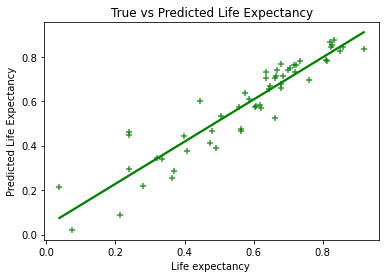

In [12]:
sns.regplot(x=y_test, y=y_pred, ci=None, color="g", marker='+')
plt.ylabel('Predicted Life Expectancy')
plt.title('True vs Predicted Life Expectancy')
plt.show()

### 3. Imputation with additional columns so model knows if data comes from actual data or imputed data.

In [13]:
updated_df3 = df
scaler = MinMaxScaler() 
updated_df3 = scaler.fit_transform(updated_df3)
updated_df3 = pd.DataFrame(updated_df3, columns=column_names)
y1 = updated_df3['Life expectancy ']
updated_df3 = updated_df3.drop(['Life expectancy '], axis=1)
for column in updated_df3.columns:
    updated_df3[column+'_ismissing'] = updated_df3[column].isnull()
    
from sklearn.impute import SimpleImputer
my_imputer = SimpleImputer(strategy = 'mean')
updated_df3 = my_imputer.fit_transform(updated_df3)
#print(updated_df3.info())
X_train, X_test,y_train,y_test = train_test_split(updated_df3,y1,test_size=0.3, random_state=2)
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Mean absolute error: {mae:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')
print(f'R^2 on train data: {lr.score(X_train, y_train)}')
print(f'R^2 on test data: {lr.score(X_test, y_test)}')

Mean absolute error: 0.06
Mean squared error: 0.01
Root mean squared error: 0.08
R^2 on train data: 0.86209933244742
R^2 on test data: 0.8614325439932242


Exact same evaluation as 2 so not to be chosen due to increased number of variables. Clearly imputation does not affect outcome.

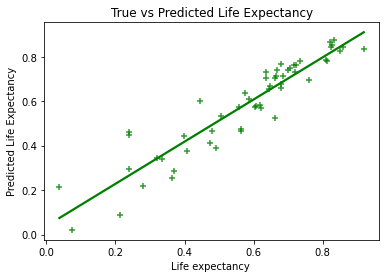

In [14]:
sns.regplot(x=y_test, y=y_pred, ci=None, color="g", marker='+')
plt.ylabel('Predicted Life Expectancy')
plt.title('True vs Predicted Life Expectancy')
plt.show()

## Conclusion

The best multiple linear regression model was produced in 2 by replacing missiing data with mean or mode dependent on the type of data. This produced an R^2 score of 0.86 therefore it predicts the life expectancy of 86% of new countries inputted correctly. This is very accurate and has great generalisability. 

#### What does this mean?
We have found that using multiple linear regression we can predict the life expectancy of a country based upon its other health data from WHO. 

#### Further ideas?
Could try another type of regression model such as Ridge, Lasso or Partial Least Squares (PLS).